# NB-HI2: Plot of Runoff, ET, Precipt over three 30yr period for each GCM

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2
pandas 1.2.1


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize

Last executed: 2021-04-05 08:54:45.469993 by mizukami on casper14


In [3]:
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster(processes=9, threads=4, memory="108GB",
#                  walltime='00:40:00')
#cluster.scale(jobs=3)

#from dask_jobqueue import SLURMCluster
#cluster = SLURMCluster()
#cluster.scale(jobs=5)

In [4]:
#from dask.distributed import Client
#client = Client(cluster)

In [5]:
#client

-------------------------
## Setup 

In [6]:
figSave = True

In [7]:
region           = 'HI'
gcms             = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
period_hist      = slice('1970-01-01', '1999-12-31')
period_10yr_hist = slice('1990-01-01', '1999-12-31')
hydro_flux_vars  = ['PRCP','EVAP', 'total_runoff']

## Load the data

In [8]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=hydro_flux_vars, region=region, parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [01:18<00:00,  7.88s/it]

load_obs_dataset


## 30 year (1970-1999) annual mean

In [9]:
histo_hydro_means = {}
for name in ['obs', 'gcm']:
    histo_hydro_means[name] = resample_data(histo_data[name].sel(time=period_hist), region=region, freq='AS').persist().mean('time')

## 10 year (1990-1999) annual mean

In [10]:
histo_hydro_10yr_means = {}
for name in ['obs', 'gcm']:
    histo_hydro_10yr_means[name] = resample_data(histo_data[name].sel(time=period_10yr_hist), region=region, freq='AS').persist().mean('time')

### Plot

In [11]:
# create colormap
# ---------------

# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.Spectral_r(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])

## 30 year (1970-1999) annual mean plot

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

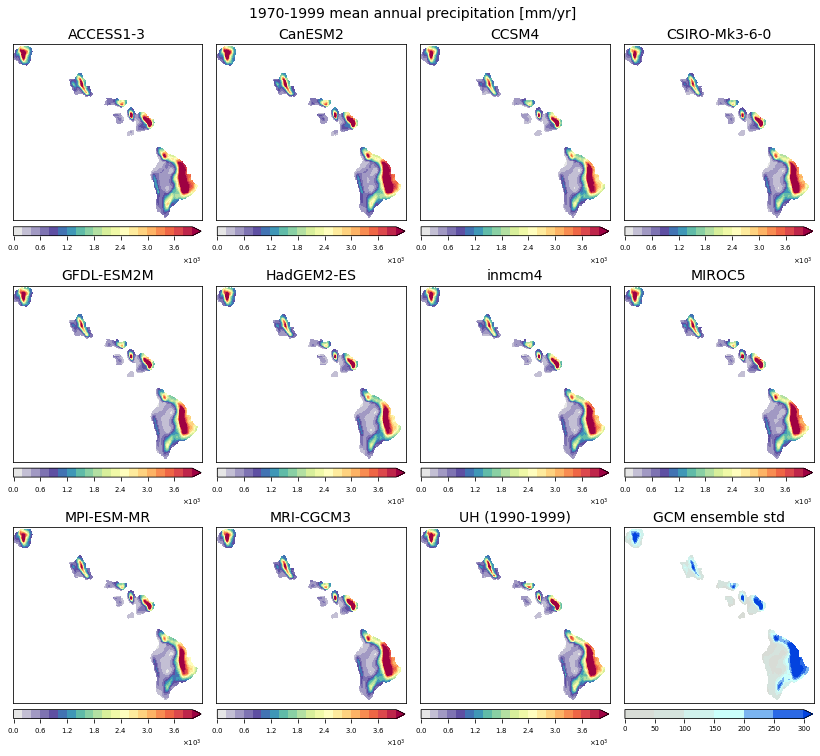

In [47]:
var="PRCP"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 7, 'vmin':0, 'vmax':300,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH (1990-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_hydro_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_hydro_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_hydro_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
#plt.tight_layout()
fig.suptitle('1970-1999 mean annual precipitation [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig1_annual_mean_{var}_hist.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

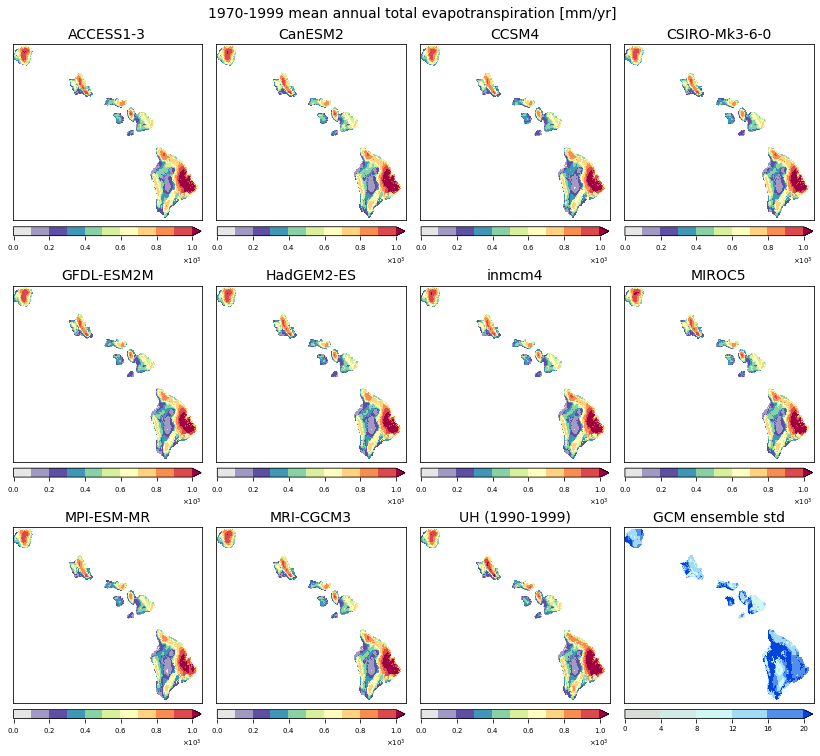

In [42]:
var="EVAP"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 11, 'vmin':0, 'vmax':1000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 6, 'vmin':0, 'vmax':20, 'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH (1990-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_hydro_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        #histo_hydro_means['gcm'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
        histo_hydro_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_hydro_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)

fig.suptitle('1970-1999 mean annual total evapotranspiration [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig2_annual_mean_{var}_hist.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

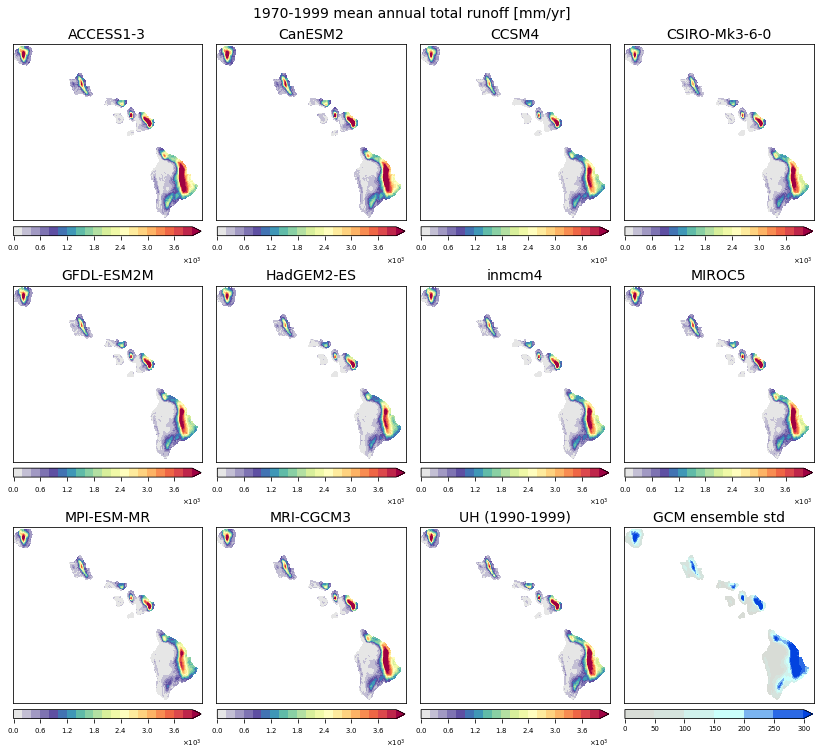

In [43]:
var="total_runoff"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 7, 'vmin':0, 'vmax':300,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH (1990-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_hydro_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_hydro_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_hydro_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('1970-1999 mean annual total runoff [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig3_annual_mean_{var}_hist.png', dpi=300)

## 10 year (1990-1999) annual mean plot

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

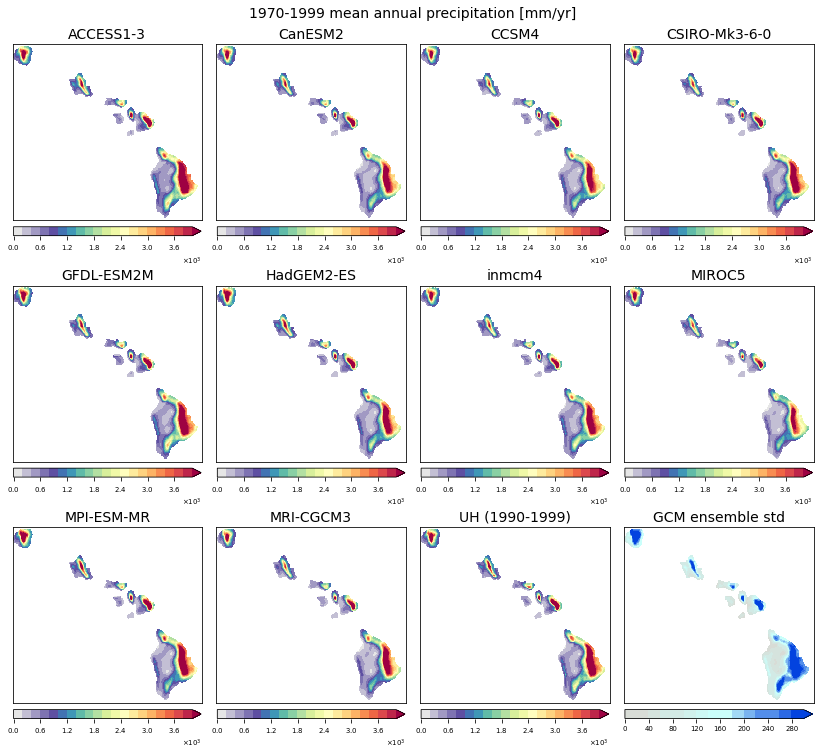

In [44]:
var="PRCP"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 16, 'vmin':0, 'vmax':300,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH (1990-1999)','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_hydro_10yr_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_hydro_10yr_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_hydro_10yr_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
#plt.tight_layout()
fig.suptitle('1970-1999 mean annual precipitation [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig4_annual_mean_{var}_10yr_hist.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

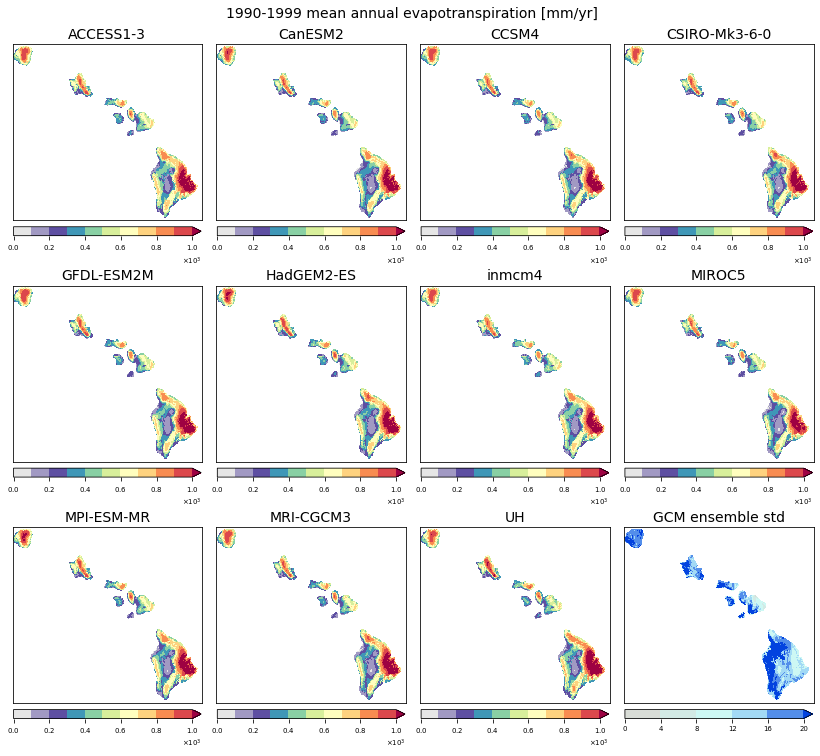

In [46]:
var="EVAP"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 11, 'vmin':0, 'vmax':1000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 6, 'vmin':0, 'vmax':20, 'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_hydro_10yr_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_hydro_10yr_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_hydro_10yr_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('1990-1999 mean annual evapotranspiration [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig5_annual_mean_{var}_10yr_hist.png', dpi=300)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

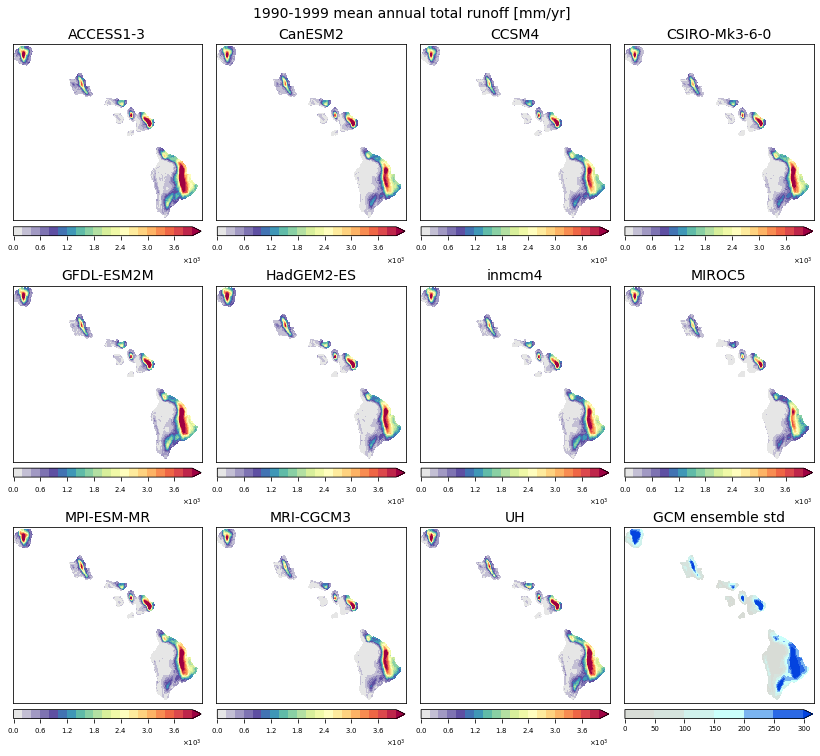

In [45]:
var="total_runoff"

cm = {'mean': cmap,
      'std' : custom_div_cmap(mincol='xkcd:light grey', midcol='xkcd:light light blue', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'mean':   {"orientation":"horizontal", "shrink":0.990, "pad":0.03, 'format':sfmt},
              'std':    {"orientation":"horizontal", "shrink":0.990, "pad":0.03}}

style_kwargs = {'mean': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['mean']},
                'std':  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['std']}}

kwargs = {'mean': {'levels': 21, 'vmin':0, 'vmax':4000, 'cmap':cm['mean'], 'extend':'max', **style_kwargs['mean']},
          'std':  {'levels': 7, 'vmin':0, 'vmax':300,  'cmap':cm['std'],  'extend':'max', **style_kwargs['std']}}

fig, axes = plt.subplots(nrows=3, ncols=4, sharex=True, sharey=True, figsize=(11.375, 10.5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.012, bottom=0.0125, right=0.99, top=0.935, hspace=0.125, wspace=0.075)

for ix, gcm in enumerate(gcms+['UH','GCM ensemble std']):
    row = ix // 4
    col = ix % 4
    if ix < 10:
        histo_hydro_10yr_means['gcm'][var].sel(gcm=gcm).plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 10:
        histo_hydro_10yr_means['obs'][var].plot.pcolormesh(ax=axes[row, col], **kwargs['mean'])
    elif ix == 11:
        histo_hydro_10yr_means['gcm'].std(dim='gcm')[var].plot.pcolormesh(ax=axes[row, col], **kwargs['std'])
    axes[row, col].set_title(gcm, fontsize=14)
    
fig.suptitle('1990-1999 mean annual total runoff [mm/yr]', fontsize=14, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig6_annual_mean_{var}_10yr_hist.png', dpi=300)

## Cofficient of variation for each variables

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


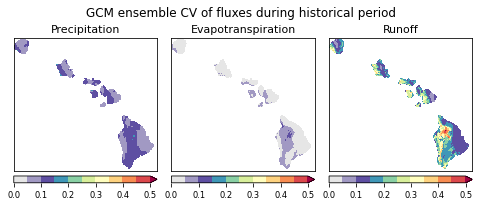

In [27]:
# uncertainty
cm = {'cv': cmap}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", pad=0.03)}
kwargs = {'cv': {'levels':11, 'vmin':0, 'vmax':0.5, 'cmap':cm['cv'], 'extend':'max', **style_kwargs}}

var_title = {'PRCP':'Precipitation', 'EVAP':'Evapotranspiration', 'total_runoff':'Runoff'}

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(6.5, 2.75)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.015, bottom=0.005, right=0.995, top=0.825, hspace=0.1, wspace=0.1)

for ix, var in enumerate(hydro_flux_vars):
    mean = histo_hydro_means['gcm'].mean(dim='gcm')[var]
    std  = histo_hydro_means['gcm'].std(dim='gcm')[var]
    cv   = std/abs(mean)
    cv.plot.pcolormesh(ax=axes[ix], **kwargs['cv'])
    axes[ix].set_title('%s'%var_title[var], fontsize=11)
    
fig.suptitle('GCM ensemble CV of fluxes during historical period', fontsize=12, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig7_cv_hist.png', dpi=300)

## obs vs GCM ensemble - 10 year (1990-1999) annual mean

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

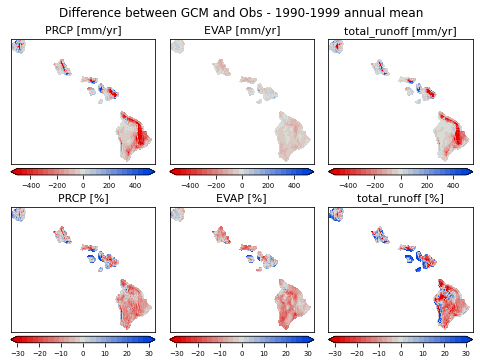

In [32]:
mpl.rcParams['xtick.labelsize']='x-small'
cm = {'diff' : custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

style_kwargs =  {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': dict(orientation="horizontal", pad=0.03)}
kwargs = {'diff': {'vmin':-500, 'vmax':500, 'cmap':cm['diff'], 'extend':'both', **style_kwargs},
          'pdiff': {'vmin':-30, 'vmax':30, 'cmap':cm['diff'], 'extend':'both', **style_kwargs}}

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(6.5, 5)) # used to be figsize=(14,11)
plt.subplots_adjust(left=0.0075, bottom=0.005, right=0.995, top=0.895, hspace=0.1, wspace=0.1)

for ix, var in enumerate(hydro_flux_vars):

    diff  = histo_hydro_10yr_means['gcm'].mean(dim='gcm')[var] - histo_hydro_10yr_means['obs'][var]
    ave   = (histo_hydro_10yr_means['gcm'].mean(dim='gcm')[var] + histo_hydro_10yr_means['obs'][var])/2.0
    pdiff = 100 * (histo_hydro_10yr_means['gcm'].mean(dim='gcm')[var] - histo_hydro_10yr_means['obs'][var])/ave
    
    diff.plot.pcolormesh(ax=axes[0, ix], **kwargs['diff'])
    pdiff.plot.pcolormesh(ax=axes[1, ix], **kwargs['pdiff'])
    axes[0,ix].set_title('%s [mm/yr]'%var, fontsize=11)
    axes[1,ix].set_title('%s [%%]'%var, fontsize=11)
    
fig.suptitle('Difference between GCM and Obs - 1990-1999 annual mean', fontsize=12, y=0.985)
if figSave:
    plt.savefig(f'NB-HI2_Fig8_obs_vs_gcm_10yr_hist.png', dpi=300)

In [ ]:
var="runoffRatio"

notnull = pd.notnull(ds_hist_yr[var])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,3))

ds_hist_yr[var].where(notnull).plot.pcolormesh(
    ax=axes[0], vmin=0, vmax=1, cmap='Spectral_r',
    add_colorbar=True, extend='both')

ds_rcp85_yr[var].where(notnull).plot.pcolormesh(
    ax=axes[1], vmin=0, vmax=1, cmap='Spectral_r',
    add_colorbar=True, extend='both')

ds_diff_yr[var].where(notnull).plot.pcolormesh(
    ax=axes[2], vmin=-0.1, vmax=.1, cmap='RdBu',
    add_colorbar=True, extend='both')

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
    
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    
axes[0].set_title('hist')
axes[1].set_title('rcp85')
axes[2].set_title('rcp85-hist')

plt.tight_layout()
fig.suptitle('Annual runoff ratio [-]', fontsize=16, y=1.02)
plt.savefig("icar_access13_yr_roratio.png", dpi=200)

### Below is for checking random things

In [ ]:
ds_rcp85_mon = ds_rcp85.groupby('time.month').mean(dim="time")

Long-term seasonal mean

In [ ]:
ds_rcp85_season = ds_rcp85.groupby('time.season').mean(dim="time")